In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

In [2]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


## Spin up dask cluster

In [3]:
# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

In [4]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/zephyrs/proxy/45443/status'})

# Setup your client
client = Client(cluster)
# Setup your PBSCluster - make sure that it uses the casper queue
cluster = PBSCluster(queue='casper')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37984 instead
  http_address["port"], self.http_server.port


# Load Data

In [5]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the climate



In [6]:
## Compute the properties of the unperturbed climate
# The mean
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
# Standard deviation of anomalies
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)

## Compute the properties of the current climate: 1990-2020
# The mean
ds_curr_mean = (
        ds_djf.sel(time=slice(1990, 2020))
        .mean(dim=['time', 'member_id'])
        .compute()
)

## Compute the properties of the future climate: 2070-2100
# The mean
ds_fut_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)

## Make it polar plottable

In [7]:
# Polar Plottable
dsp_gp = util.pop_add_cyclic(
    xr.Dataset({
        'ctrl': ds_ctrl_mean.KGP,
        'curr':ds_curr_mean.KGP,
        'stdev': ds_ctrl_std.KGP,
        'future':ds_fut_mean.KGP,
        'change': ds_fut_mean.KGP - ds_curr_mean.KGP,

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
#dsp_gp

### find the highest krill growth rate in both epochs:

In [17]:
print('current max gp rate:',np.round(dsp_gp.curr.max().values, 3), ', future max gp rate:',np.round(dsp_gp.future.max().values, 3))

current max gp rate: 0.218 , future max gp rate: 0.213


In [14]:
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()

future_gp = [0, dsp_gp.future.max().values]
current_gp = [0, dsp_gp.curr.max().values]

def bones(da, postive_growth):
    # contour lines: dc.where(dc>0)
    cf = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k', 
                    levels=postive_growth,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
#     land = ax.add_feature(
#         cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
#                                             facecolor='lightgray'))
#     ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

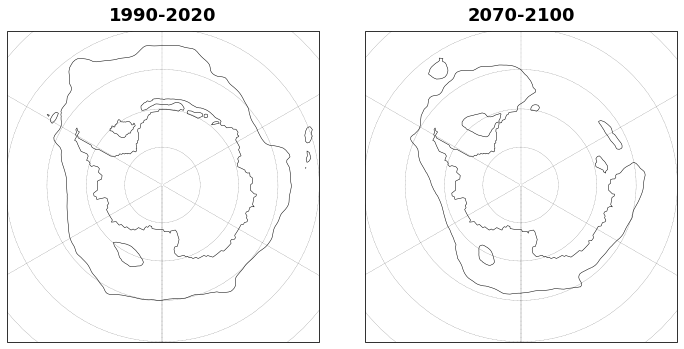

In [16]:
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2,2, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, unit = '1990-2020', '2070-2100', 'mm day$^{-1}}$'
dsp = dsp_gp

################### LEFT MOST PLOT: Current Mean ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

cf = bones(dsp.curr, current_gp)

################### MIDDLE PLOT: Future Mean ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

cf = bones(dsp.future, future_gp)